# Imports

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
from sklearn.metrics import mean_absolute_percentage_error #MAPE metrica de error
from prophet.diagnostics import cross_validation
import plotly.express as px # El famoso plotly que brinda unos gráficos maravillosos
import plotly.graph_objects as go # Usado para graficar intervalos de confianza en los modelos
from scipy.stats import boxcox # boxcox transformation
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
df = pd.read_csv('series.csv')

In [3]:
df.head()

CATEGORY        DATE  UNITS_SOLD
0  CATEG-1  2021-08-17          59
1  CATEG-1  2020-09-19          40
2  CATEG-2  2021-10-26          23
3  CATEG-1  2021-04-27          60
4  CATEG-2  2021-05-05          61

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


In [5]:
df.CATEGORY.value_counts()

CATEG-3    920
CATEG-1    887
CATEG-2    879
Name: CATEGORY, dtype: int64

# Tweak function

In [6]:
def tweak_function(df: pd.DataFrame):
    """Algunos ajustes iniciales al dataset"""
    return (df
            .assign(DATE =  pd.to_datetime(df['DATE']))
           )

In [7]:
df = tweak_function(df)

# Desarrollo

## Paso 1 -  Se agrupan las ventas por categoria

In [8]:
df_cat_1 = df.loc[df['CATEGORY'] == 'CATEG-1']
df_cat_1 = df_cat_1.sort_values(['DATE'])

df_cat_2 = df.loc[df['CATEGORY'] == 'CATEG-2']
df_cat_2 = df_cat_2.sort_values(['DATE'])

df_cat_3 = df.loc[df['CATEGORY'] == 'CATEG-3']
df_cat_3 = df_cat_3.sort_values(['DATE'])

## Paso 2 - EDA

Text(0.5, 1.0, 'UNITS SOLD CATEG 1')

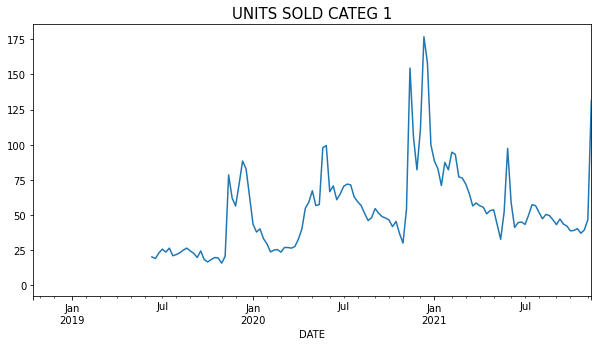

In [9]:
(df_cat_1.groupby([pd.Grouper(key='DATE', freq='w')])['UNITS_SOLD'].mean()).plot(figsize = (10,5))
plt.title('UNITS SOLD CATEG 1' , fontsize = 15)

Text(0.5, 1.0, 'UNITS SOLD CATEG 2')

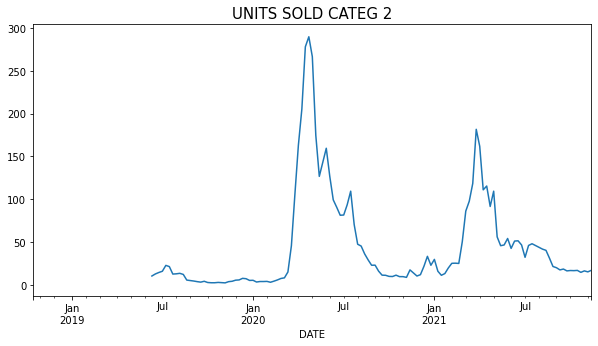

In [10]:
(df_cat_2.groupby([pd.Grouper(key='DATE', freq='w')])['UNITS_SOLD'].mean()).plot(figsize = (10,5))
plt.title('UNITS SOLD CATEG 2' , fontsize = 15)

Text(0.5, 1.0, 'UNITS SOLD CATEG 3')

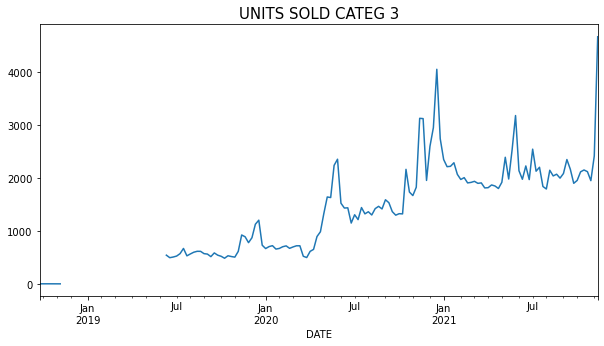

In [11]:
(df_cat_3.groupby([pd.Grouper(key='DATE', freq='w')])['UNITS_SOLD'].mean()).plot(figsize = (10,5))
plt.title('UNITS SOLD CATEG 3' , fontsize = 15)

Vamos a limpiar los datos removiendo todas las obserbaciones menores al 01/06/2019

In [12]:
df_cat_1 = df_cat_1[df_cat_1['DATE'].dt.date > datetime.date(2019, 6, 1)]
df_cat_2 = df_cat_2[df_cat_2['DATE'].dt.date > datetime.date(2019, 6, 1)]
df_cat_3 = df_cat_3[df_cat_3['DATE'].dt.date > datetime.date(2019, 6, 1)]

## Paso 3 - Plot ventas por categoria


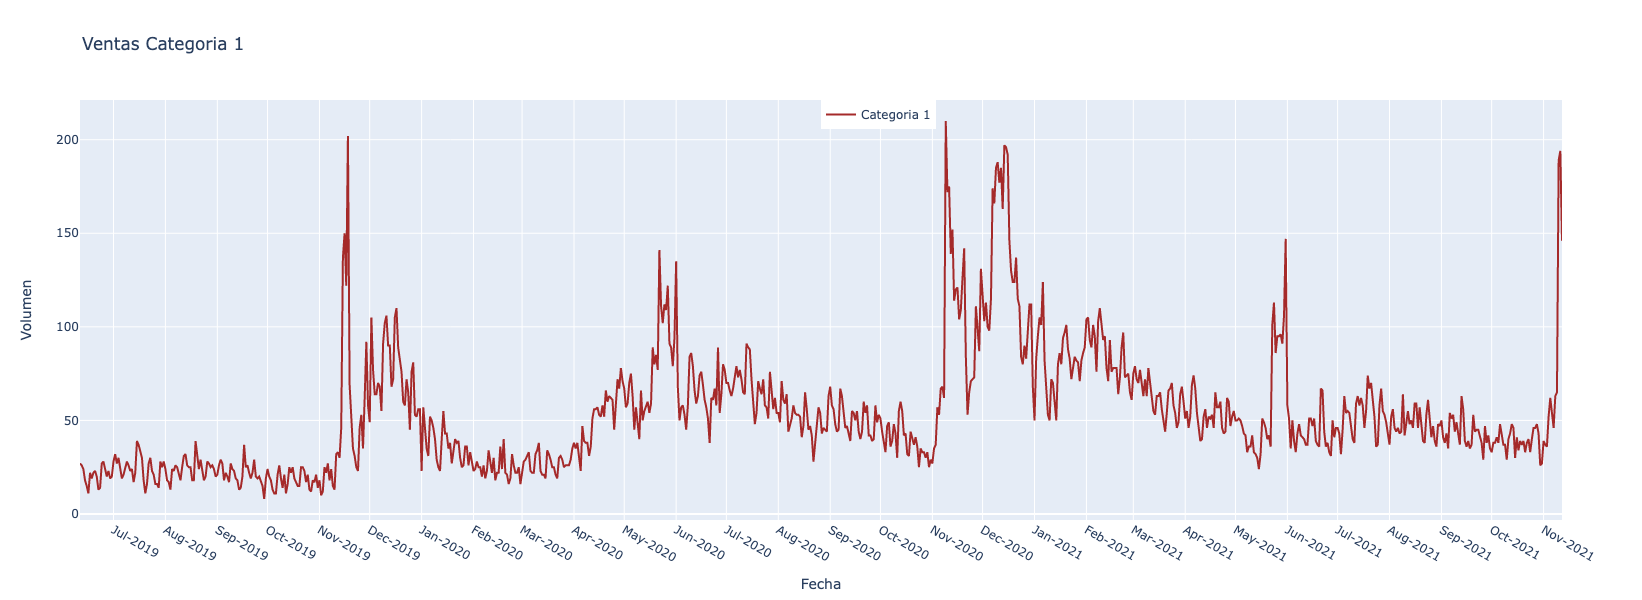

In [14]:
# Se grafica usando la librería plotly -- CATEGORIA 1 ---

df_plotly_cat_1 = df_cat_1.reset_index()
fig = (px.line(df_plotly_cat_1, x="DATE", y="UNITS_SOLD", title="Ventas Categoria 1", color_discrete_sequence=['brown'])
       .update_layout(xaxis_title= "Fecha", yaxis_title="Volumen", width=1400, height=600)
      )
fig.data[0].name = "Categoria 1"
fig.update_traces(showlegend=True)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    x=0.5,
    y=1
))

fig.update_xaxes(
    dtick = "M1",
    tickformat="%b-%Y"
)

fig.show()

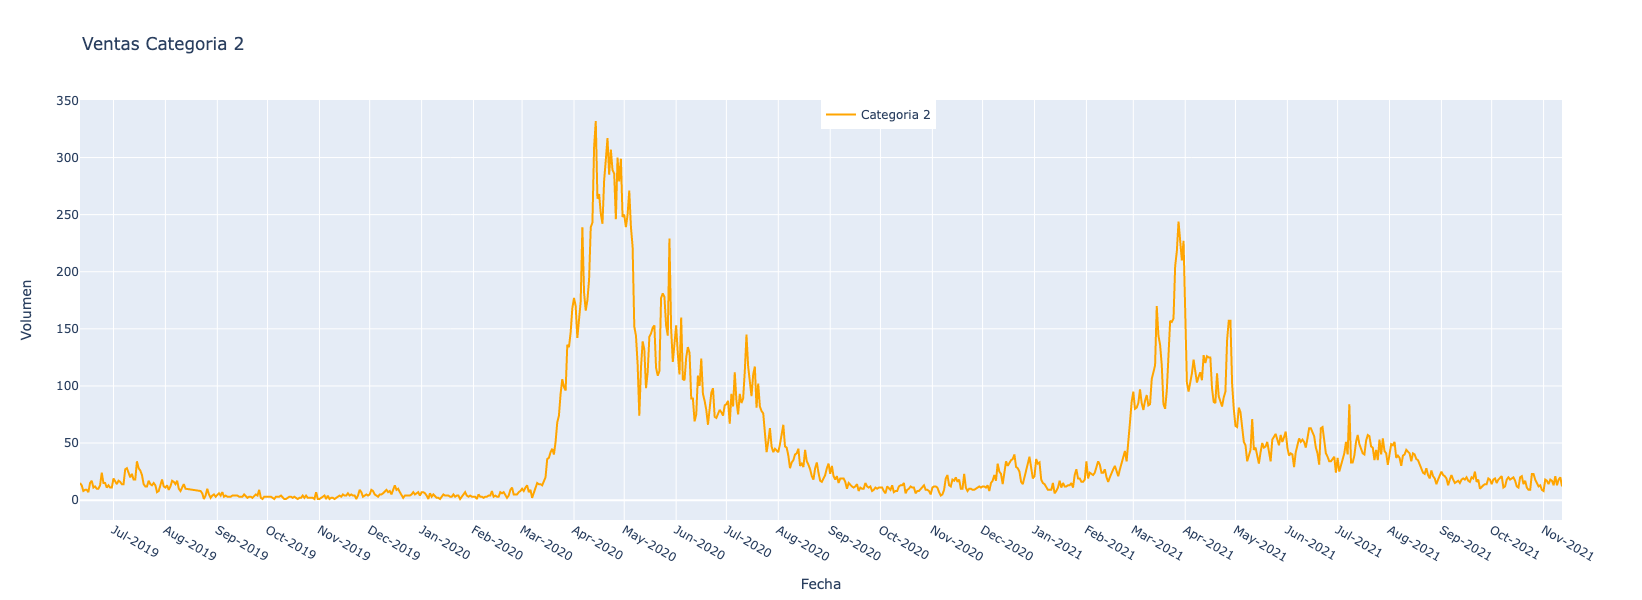

In [15]:
# Se grafica usando la librería plotly -- CATEGORIA 2 ---


df_plotly_cat_2 = df_cat_2.reset_index()
fig = (px.line(df_plotly_cat_2, x="DATE", y="UNITS_SOLD", title="Ventas Categoria 2", color_discrete_sequence=['orange'])
       .update_layout(xaxis_title= "Fecha", yaxis_title="Volumen", width=1400, height=600)
      )
fig.data[0].name = "Categoria 2"
fig.update_traces(showlegend=True)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    x=0.5,
    y=1
))

fig.update_xaxes(
    dtick = "M1",
    tickformat="%b-%Y"
)

fig.show()

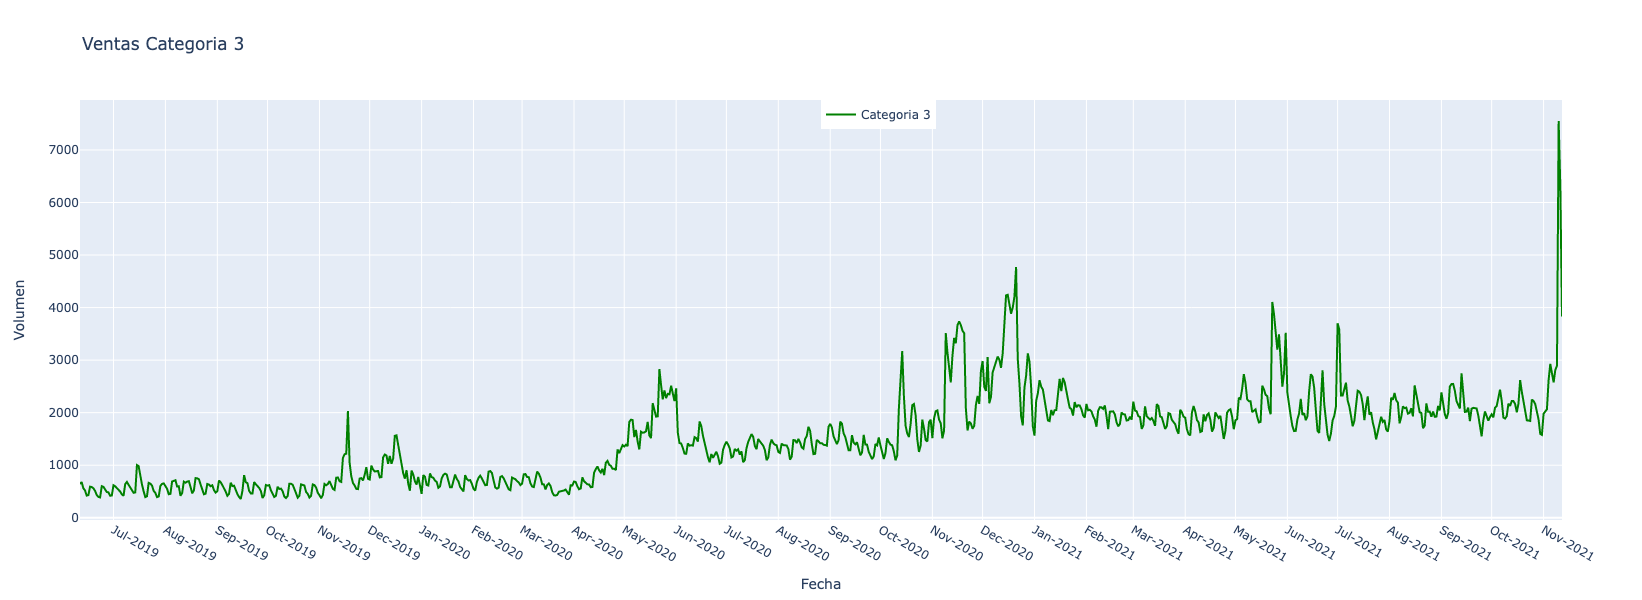

In [16]:
# Se grafica usando la librería plotly -- CATEGORIA 3 ---

df_plotly_cat_3 = df_cat_3.reset_index()
fig = (px.line(df_plotly_cat_3, x="DATE", y="UNITS_SOLD", title="Ventas Categoria 3", color_discrete_sequence=['green'])
       .update_layout(xaxis_title= "Fecha", yaxis_title="Volumen", width=1400, height=600)
      )
fig.data[0].name = "Categoria 3"
fig.update_traces(showlegend=True)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    x=0.5,
    y=1
))

fig.update_xaxes(
    dtick = "M1",
    tickformat="%b-%Y"
)

fig.show()

## Paso 4 - Gráfica aumento ventas por Categoria


Aumento de ventas diario

In [17]:
df_cat_1['shift_units_sold'] = df_cat_1['UNITS_SOLD'].shift(1, axis=0)
df_cat_1['aumento_ventas_diario'] = df_cat_1['UNITS_SOLD'] - df_cat_1['shift_units_sold']

df_cat_2['shift_units_sold'] = df_cat_2['UNITS_SOLD'].shift(1, axis=0)
df_cat_2['aumento_ventas_diario'] = df_cat_2['UNITS_SOLD'] - df_cat_2['shift_units_sold']

df_cat_3['shift_units_sold'] = df_cat_3['UNITS_SOLD'].shift(1, axis=0)
df_cat_3['aumento_ventas_diario'] = df_cat_3['UNITS_SOLD'] - df_cat_3['shift_units_sold']

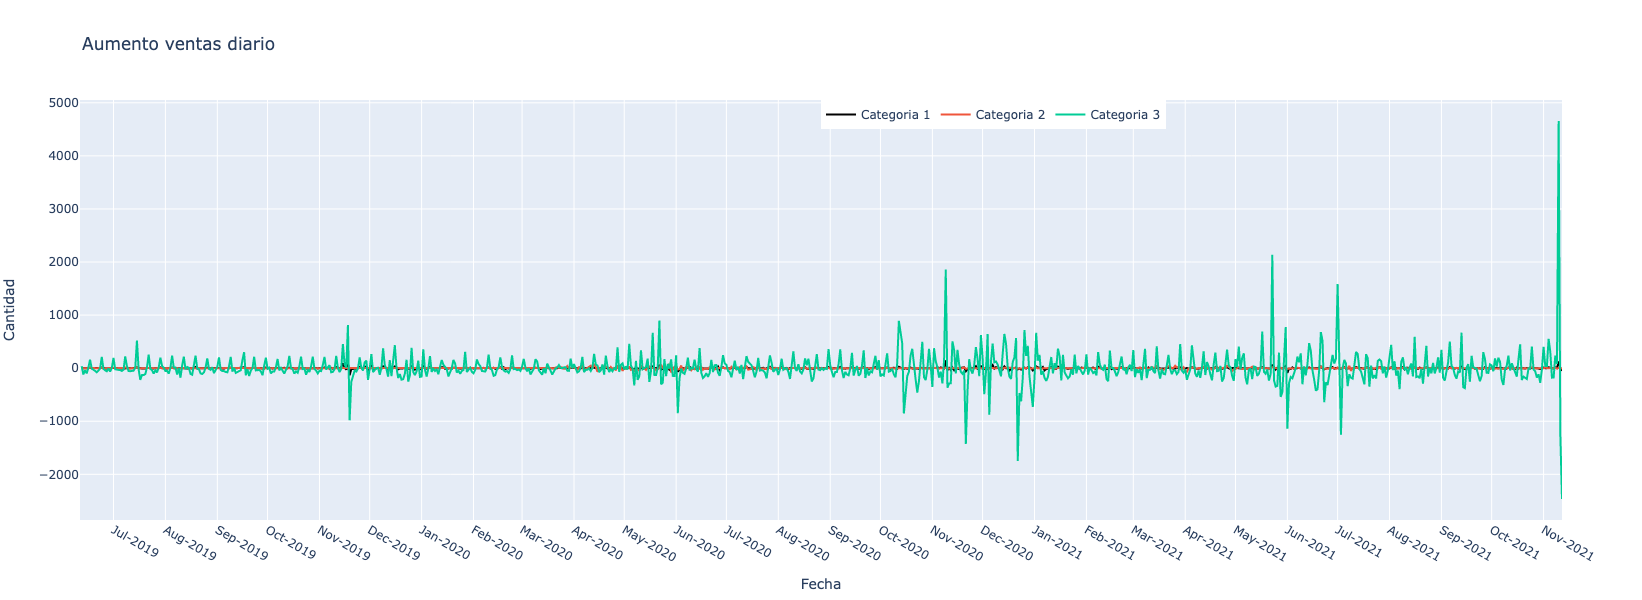

In [18]:
# Se grafica el aumento que hubo de ventas por Categoria usando la librería plotly

fig = (px.line(df_cat_1, x="DATE", 
               y="aumento_ventas_diario", 
               title="Aumento ventas diario", color_discrete_sequence=['black']
              )
       .update_layout(xaxis_title= "Fecha", yaxis_title="Cantidad", width=1400, height=600)
      )
fig.data[0].name = "Categoria 1"
fig.update_traces(showlegend=True)
fig.add_scatter(x=df_cat_2["DATE"], 
                y=df_cat_2["aumento_ventas_diario"], 
                name="Categoria 2"
               )
fig.add_scatter(x=df_cat_3["DATE"], 
                y=df_cat_3["aumento_ventas_diario"], 
                name="Categoria 3"
               )

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    x= 0.5,
    y=1
))

fig.update_xaxes(
    dtick = "M1",
    tickformat="%b-%Y"
)

fig.show()

## Paso 5 - Separar TEST TRAIN


Para la separacion test - train se va a utilizar dejar las últimas 3 semanas para predecir, ya que el objetivo es predecir las siguientes 3 semanas.

Por tanto NO se va a usar el clásico 0.8 para train 0.2 para test.

Métrica a utilizar: MAPE

In [19]:
cutoff_day_for_training = df.DATE.max() - timedelta(days=21)

**Para convertirlo en df que sirva para Prophet hay que renombrar las columnas**

In [20]:
df_cat_1.columns = ['CATEGORY', 'ds', 'y', 'shift_units_sold' , 'aumento_ventas_diario'] 
df_cat_2.columns = ['CATEGORY', 'ds', 'y', 'shift_units_sold' , 'aumento_ventas_diario'] 
df_cat_3.columns = ['CATEGORY', 'ds', 'y', 'shift_units_sold' , 'aumento_ventas_diario'] 

In [21]:
df_train_cat_1 = df_cat_1.loc[(df_cat_1['ds'] <= (df_cat_1.ds.max() - timedelta(days=21))) ]
df_test_cat_1 = df_cat_1.loc[(df_cat_1['ds'] > (df_cat_1.ds.max() - timedelta(days=21))) ]

df_train_cat_2 = df_cat_2.loc[(df_cat_2['ds'] <= (df_cat_2.ds.max() - timedelta(days=21))) ]
df_test_cat_2 = df_cat_2.loc[(df_cat_2['ds'] > (df_cat_2.ds.max() - timedelta(days=21))) ]

df_train_cat_3 = df_cat_3.loc[(df_cat_3['ds'] <= (df_cat_3.ds.max() - timedelta(days=21))) ]
df_test_cat_3 = df_cat_3.loc[(df_cat_3['ds'] > (df_cat_3.ds.max() - timedelta(days=21))) ]

In [22]:
m_cat_1 = Prophet()
m_cat_1.fit(df_train_cat_1[['ds','y','aumento_ventas_diario']])

m_cat_2 = Prophet()
m_cat_2.fit(df_train_cat_2[['ds','y','aumento_ventas_diario']])

m_cat_3 = Prophet()
m_cat_3.fit(df_train_cat_3[['ds','y','aumento_ventas_diario']])

15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing
15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing
15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing


## Paso 6 - Cross validation

In [23]:
df_train_cat_1.ds.max()-df_train_cat_1.ds.min()

Timedelta('864 days 00:00:00')

In [24]:
df_train_cat_2.ds.max()-df_train_cat_2.ds.min()

Timedelta('864 days 00:00:00')

In [25]:
df_train_cat_3.ds.max()-df_train_cat_3.ds.min()

Timedelta('864 days 00:00:00')

Si suponemos 5 folds de 21 dias cada holdout de validation, serian entonces 105 dias menos del total los necesarios para el primer set de training.

864 - 105 = 759 dias

In [61]:
from prophet.diagnostics import cross_validation
df_cv_cat_1 = cross_validation(m_cat_1, 
                         initial='759 days', 
                         period='21 days', 
                         horizon = '21 days')

df_cv_cat_2 = cross_validation(m_cat_2, 
                         initial='759 days', 
                         period='21 days', 
                         horizon = '21 days')

df_cv_cat_3 = cross_validation(m_cat_3, 
                         initial='759 days', 
                         period='21 days', 
                         horizon = '21 days')

  0%|          | 0/5 [00:00<?, ?it/s]

14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing
14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing
14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing
14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:02 - cmdstanpy - INFO - Chain [1] done processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:03 - cmdstanpy - INFO - Chain [1] done processing
14:56:03 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing


## Paso 7 - Predicciones

In [62]:
# Python
future_cat_1 = m_cat_1.make_future_dataframe(periods=21)
future_cat_2 = m_cat_3.make_future_dataframe(periods=21)
future_cat_3 = m_cat_3.make_future_dataframe(periods=21)

In [63]:
forecast_cat_1 = m_cat_1.predict(future_cat_1)
forecast_cat_2 = m_cat_2.predict(future_cat_2)
forecast_cat_3 = m_cat_3.predict(future_cat_3)

## Paso 8 - Error: MAPE

In [64]:
print("Prophet - Error en Categoria 1")
print(mean_absolute_percentage_error(df_test_cat_1["y"], forecast_cat_1['yhat'].tail(21)))
print("Prophet - Error en Categoria 2")
print(mean_absolute_percentage_error(df_test_cat_2["y"], forecast_cat_2['yhat'].tail(21)))
print("Prophet - Error en Categoria 3")
print(mean_absolute_percentage_error(df_test_cat_3["y"], forecast_cat_3['yhat'].tail(21)))

Prophet - Error en Categoria 1
0.2839596980364385
Prophet - Error en Categoria 2
0.3240657130390804
Prophet - Error en Categoria 3
0.1866735997171767


## Paso 9 - Plotting trends

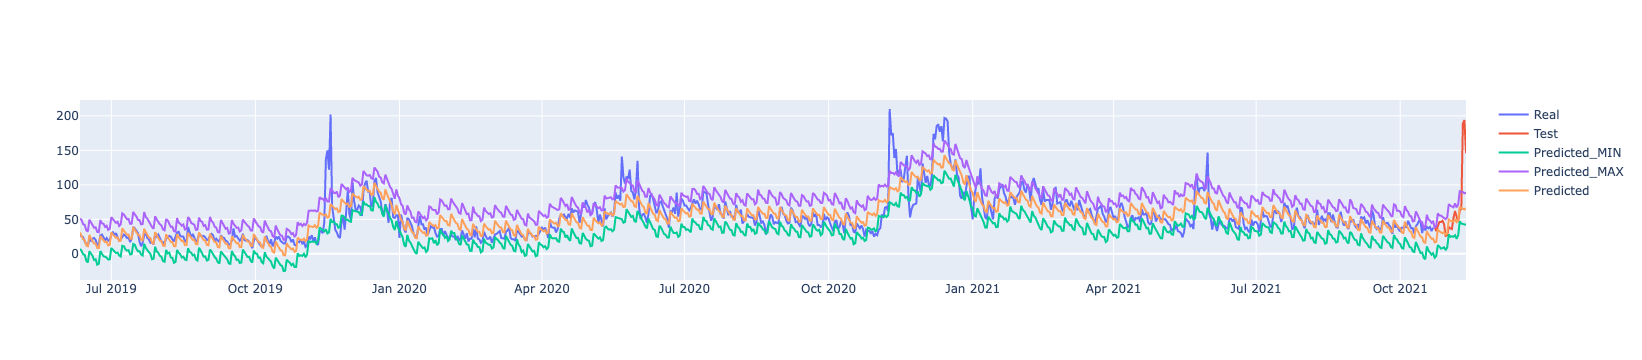

In [77]:
# Plotting Categoria 1
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train_cat_1['ds'], y= df_train_cat_1['y'], name= 'Real',))
fig.add_trace(go.Scatter(x=df_test_cat_1['ds'], y= df_test_cat_1['y'], name= 'Test',))
fig.add_trace(go.Scatter(x=forecast_cat_1['ds'], y= forecast_cat_1['yhat_lower'], name= 'Predicted_MIN',))
fig.add_trace(go.Scatter(x=forecast_cat_1['ds'], y= forecast_cat_1['yhat_upper'], name= 'Predicted_MAX',))
fig.add_trace(go.Scatter(x=forecast_cat_1['ds'], y= forecast_cat_1['yhat'], name= 'Predicted',))
fig.show()


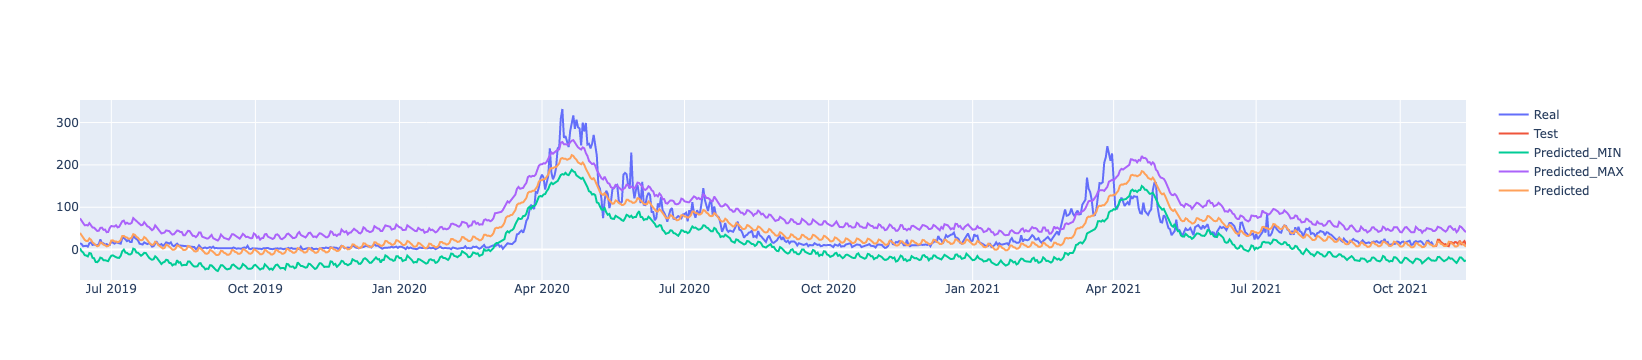

In [78]:
# Plotting Categoria 2
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train_cat_2['ds'], y= df_train_cat_2['y'], name= 'Real',))
fig.add_trace(go.Scatter(x=df_test_cat_2['ds'], y= df_test_cat_2['y'], name= 'Test',))
fig.add_trace(go.Scatter(x=forecast_cat_2['ds'], y= forecast_cat_2['yhat_lower'], name= 'Predicted_MIN',))
fig.add_trace(go.Scatter(x=forecast_cat_2['ds'], y= forecast_cat_2['yhat_upper'], name= 'Predicted_MAX',))
fig.add_trace(go.Scatter(x=forecast_cat_2['ds'], y= forecast_cat_2['yhat'], name= 'Predicted',))
fig.show()

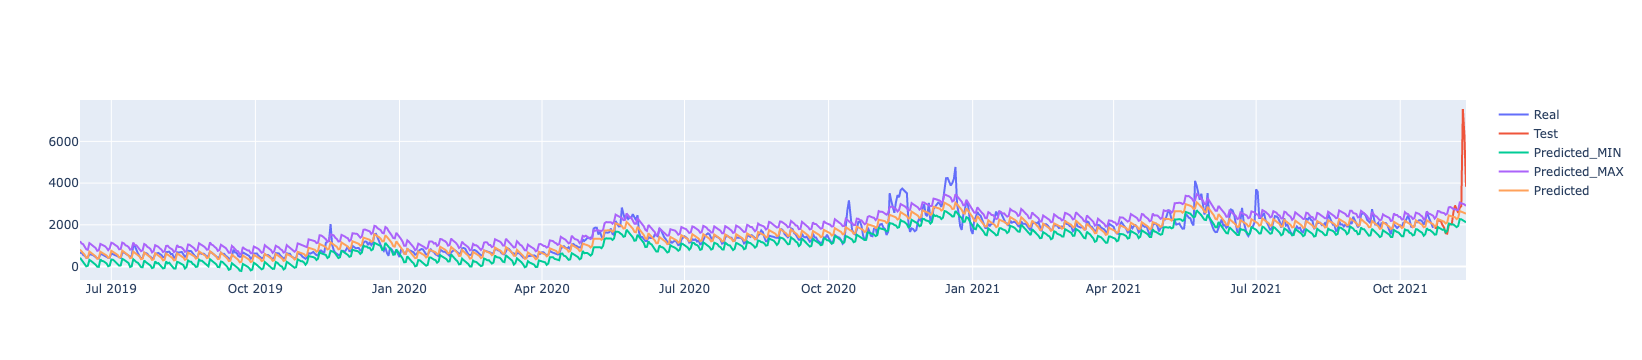

In [79]:
# Plotting Categoria 3
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train_cat_3['ds'], y= df_train_cat_3['y'], name= 'Real',))
fig.add_trace(go.Scatter(x=df_test_cat_3['ds'], y= df_test_cat_3['y'], name= 'Test',))
fig.add_trace(go.Scatter(x=forecast_cat_3['ds'], y= forecast_cat_3['yhat_lower'], name= 'Predicted_MIN',))
fig.add_trace(go.Scatter(x=forecast_cat_3['ds'], y= forecast_cat_3['yhat_upper'], name= 'Predicted_MAX',))
fig.add_trace(go.Scatter(x=forecast_cat_3['ds'], y= forecast_cat_3['yhat'], name= 'Predicted',))
fig.show()

## Paso 10 - Transformación BOXCOX


Vamos a aplicar esta transformacion para obtener mejores resultados.

El objetivo es que nuestra variable target se parezca mas a una distribucion normal.

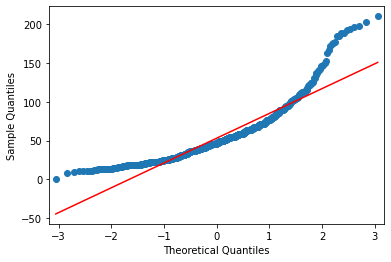

In [99]:
qqplot(df_cat_1['y'] , line='s')
plt.show()

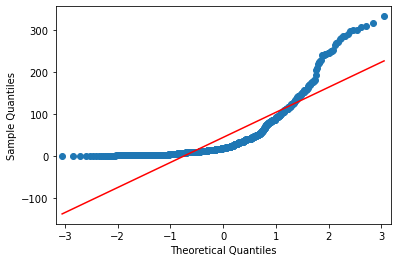

In [100]:
qqplot(df_cat_2['y'] , line='s')
plt.show()

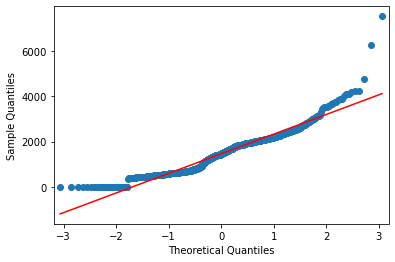

In [102]:
qqplot(df_cat_3['y'] , line='s')
plt.show()

In [26]:
# Aplico transformación boxcox
df_cat_1["y"], _ =boxcox(df_cat_1['y'])
df_cat_2["y"], _ =boxcox(df_cat_2['y'])
df_cat_3["y"], _ =boxcox(df_cat_3['y'])


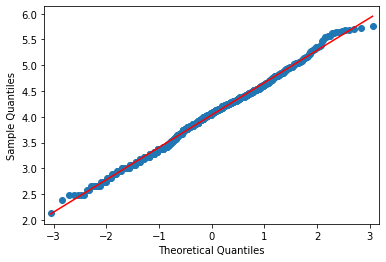

In [27]:
qqplot(df_cat_1['y'] , line='s')
plt.show()

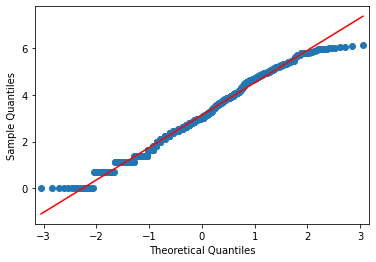

In [29]:
qqplot(df_cat_2['y'] , line='s')
plt.show()

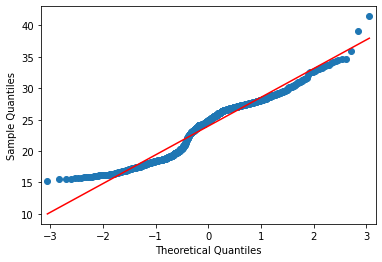

In [28]:
qqplot(df_cat_3['y'] , line='s')
plt.show()

Luego de la conversion Boxcox la distribucion de la variable target para cada una de las categorias luce mas similar a una distribucion normal

In [81]:
df_train_cat_1 = df_cat_1.loc[(df_cat_1['ds'] <= (df_cat_1.ds.max() - timedelta(days=21))) ]
df_test_cat_1 = df_cat_1.loc[(df_cat_1['ds'] > (df_cat_1.ds.max() - timedelta(days=21))) ]

df_train_cat_2 = df_cat_2.loc[(df_cat_2['ds'] <= (df_cat_2.ds.max() - timedelta(days=21))) ]
df_test_cat_2 = df_cat_2.loc[(df_cat_2['ds'] > (df_cat_2.ds.max() - timedelta(days=21))) ]

df_train_cat_3 = df_cat_3.loc[(df_cat_3['ds'] <= (df_cat_3.ds.max() - timedelta(days=21))) ]
df_test_cat_3 = df_cat_3.loc[(df_cat_3['ds'] > (df_cat_3.ds.max() - timedelta(days=21))) ]

In [82]:
m_cat_1 = Prophet()
m_cat_1.fit(df_train_cat_1[['ds','y','aumento_ventas_diario']])

m_cat_2 = Prophet()
m_cat_2.fit(df_train_cat_2[['ds','y','aumento_ventas_diario']])

m_cat_3 = Prophet()
m_cat_3.fit(df_train_cat_3[['ds','y','aumento_ventas_diario']])

15:09:30 - cmdstanpy - INFO - Chain [1] start processing
15:09:30 - cmdstanpy - INFO - Chain [1] done processing
15:09:30 - cmdstanpy - INFO - Chain [1] start processing
15:09:30 - cmdstanpy - INFO - Chain [1] done processing
15:09:30 - cmdstanpy - INFO - Chain [1] start processing
15:09:30 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
# Python
future_cat_1 = m_cat_1.make_future_dataframe(periods=21)
future_cat_2 = m_cat_3.make_future_dataframe(periods=21)
future_cat_3 = m_cat_3.make_future_dataframe(periods=21)

In [84]:
forecast_cat_1 = m_cat_1.predict(future_cat_1)
forecast_cat_2 = m_cat_2.predict(future_cat_2)
forecast_cat_3 = m_cat_3.predict(future_cat_3)

In [85]:
print("Prophet - Error en Categoria 1")
print(mean_absolute_percentage_error(df_test_cat_1["y"], forecast_cat_1['yhat'].tail(21)))
print("Prophet - Error en Categoria 2")
print(mean_absolute_percentage_error(df_test_cat_2["y"], forecast_cat_2['yhat'].tail(21)))
print("Prophet - Error en Categoria 3")
print(mean_absolute_percentage_error(df_test_cat_3["y"], forecast_cat_3['yhat'].tail(21)))

Prophet - Error en Categoria 1
0.07452657557657905
Prophet - Error en Categoria 2
0.09797738366491424
Prophet - Error en Categoria 3
0.06375201251720572
